# House Prices: Advanced Regression Techniques

元ネタ: Kaggleの練習問題（Regression）を解いてKagglerになる - Qiita( https://qiita.com/katsu1110/items/a1c3185fec39e5629bcb )

このページの内容をSpark準拠に書き直してみる

In [1]:
# ライブラリの読み込み
import os, sys
#import pickle
import pandas as pd
import numpy as np
import json
from IPython.core.display import display
from matplotlib import pyplot as plt
import seaborn as sns
#from itertools import chain

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").getOrCreate()
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.sql.functions import udf, col, lit, create_map

def printDf(sprkDF): 
    # format Spark Dataframe like pandas dataframe
    # sparkのdataframeをpandasのdataframeのように整形して出力する
    # 【制限】同じ名前の列が複数ある場合にはエラーになる
    newdf = sprkDF.toPandas()
    from IPython.core.display import display, HTML
    return HTML(newdf.to_html())

def fillNa(df, method):
    # fill Nan row in each column which doesn't have StringType type.
    # method can be specified items(avg, max, min, sum, count) which is defined in pyspark.dataframe.groupBy.agg
    # 文字列以外のカラムのNaN部分を埋める。文字列のカラムは無視される。
    # methodにはpyspark.dataframe.groupBy.aggで指定可能な項目(avg, max, min, sum, count)を指定する
    cols = df.columns
    for i in df.schema:
        colName = i.name
        nColName = colName + "-filled"
        colType = i.dataType
        if isinstance(colType, DoubleType):
            meanValue = df.agg({colName: method}).collect()
            def replaceNullValueDouble(beforeVal, afterVal):
                if beforeVal == None:
                    return float(afterVal)
                else:
                    return float(beforeVal)
            udfReplaceNullValueDouble = udf(replaceNullValueDouble, DoubleType())
            df2 = df.withColumn(nColName, udfReplaceNullValueDouble(df[colName], lit(meanValue[0][0]))).drop(colName).withColumnRenamed(nColName, colName)
            df = df2.select(cols)
        elif isinstance(colType, IntegerType):
            meanValue = df.agg({colName: method}).collect()
            def replaceNullValueInt(beforeVal, afterVal):
                if beforeVal == None:
                    return int(afterVal)
                else:
                    return int(beforeVal)
            udfReplaceNullValueInt = udf(replaceNullValueInt, IntegerType())
            df2 = df.withColumn(nColName, udfReplaceNullValueInt(df[colName], lit(meanValue[0][0]))).drop(colName).withColumnRenamed(nColName, colName)
            df = df2.select(cols)
        else:
            pass
    colType = df.schema[colName].dataType
    return df

def labelEncode(df, labelDict):
    # encode labels with value between 0 and n_classes-1
    # if labelDict is passed, encode label in same way as first.
    if labelDict == None:
        labelDict = {}
    cols = df.columns
    for i in df.schema:
        colName = i.name
        nColName = colName + "-encoded"
        colType = i.dataType
        if isinstance(colType, StringType):
            if colName in labelDict:
                eItems = labelDict[colName]
            else:
                eItems = {}
                for (x, i) in enumerate(df.groupBy(colName).agg({colName: "count"}).select(colName).collect()):
                    eItems[i[0]] = x
                labelDict[colName] = eItems
                print(colName, eItems)
            eItems = spark.sparkContext.broadcast(eItems)
            def colLabelEncoder(a):
                topic = eItems.value
                if a in topic:
                    return topic[a]
                else:
                    sys.stderr.write("unencoded value found: "+str(a)+". assigned -1.\n")
                    return -1
            udfColLabelEncoder = udf(colLabelEncoder, IntegerType())
            #print("going to convert "+colName)
            df2 = df.withColumn(nColName, udfColLabelEncoder(df[colName])).drop(colName).withColumnRenamed(nColName, colName)
            df = df2.select(cols)
        else:
            #print(colName, "pass")
            pass
    return (df, labelDict)

### CSVからデータファイルを読み込み

In [2]:
# CSVのデータファイルを読み込み
df = spark.read.format("csv").options(header="true", nanValue="NA", nullValue="NA", inferSchema=True).load("train.csv.gz")
#print(df.printSchema())
display(printDf(df.limit(10)))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,

### 各列毎にNull値を列の平均値で埋める

In [3]:
# Null値を平均値で埋める
df2 = fillNa(df, "mean")
display(printDf(df2.limit(10)))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,70,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0

### 文字列になっている列を、数値型に変換する

In [4]:
# String型の列をそれぞれグループ化し、整数に変換する
(df3, labelDict) = labelEncode(df2, None)
display(printDf(df3.limit(10)))
#print(labelDict)

MSZoning {'C (all)': 0, 'RH': 1, 'FV': 2, 'RL': 3, 'RM': 4}
Street {'Pave': 0, 'Grvl': 1}
Alley {None: 0, 'Pave': 1, 'Grvl': 2}
LotShape {'IR1': 0, 'IR2': 1, 'Reg': 2, 'IR3': 3}
LandContour {'Bnk': 0, 'Low': 1, 'Lvl': 2, 'HLS': 3}
Utilities {'NoSeWa': 0, 'AllPub': 1}
LotConfig {'Inside': 0, 'FR3': 1, 'Corner': 2, 'CulDSac': 3, 'FR2': 4}
LandSlope {'Sev': 0, 'Gtl': 1, 'Mod': 2}
Neighborhood {'Veenker': 0, 'BrkSide': 1, 'NPkVill': 2, 'NridgHt': 3, 'NoRidge': 4, 'NWAmes': 5, 'OldTown': 6, 'Gilbert': 7, 'Somerst': 8, 'Crawfor': 9, 'NAmes': 10, 'IDOTRR': 11, 'Edwards': 12, 'Sawyer': 13, 'StoneBr': 14, 'CollgCr': 15, 'SWISU': 16, 'MeadowV': 17, 'Timber': 18, 'Blmngtn': 19, 'Mitchel': 20, 'SawyerW': 21, 'Blueste': 22, 'BrDale': 23, 'ClearCr': 24}
Condition1 {'PosN': 0, 'RRNe': 1, 'Artery': 2, 'Feedr': 3, 'Norm': 4, 'RRNn': 5, 'RRAn': 6, 'PosA': 7, 'RRAe': 8}
Condition2 {'PosN': 0, 'Artery': 1, 'Feedr': 2, 'Norm': 3, 'RRNn': 4, 'RRAn': 5, 'PosA': 6, 'RRAe': 7}
BldgType {'Twnhs': 0, '1Fam': 1, 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65,8450,0,0,2,2,1,0,1,15,4,3,1,4,7,5,2003,2003,0,5,14,15,4,196,0,4,0,0,4,3,3,706,1,0,150,856,4,2,0,3,856,854,0,1710,1,0,2,1,3,1,0,8,4,0,1,2,2003,0,2,548,5,5,0,0,61,0,0,0,0,1,2,0,0,2,2008,7,5,208500
1,2,20,3,80,9600,0,0,2,2,1,4,1,0,3,3,1,6,6,8,1976,1976,0,5,8,9,0,0,3,4,5,0,4,0,6,978,1,0,284,1262,4,2,0,3,1262,0,0,1262,0,1,2,0,3,1,3,6,4,1,5,2,1976,0,2,460,5,5,0,298,0,0,0,0,0,1,2,0,0,5,2007,7,5,181500
2,3,60,3,68,11250,0,0,0,2,1,0,1,15,4,3,1,4,7,5,2001,2002,0,5,14,15,4,162,0,4,0,0,4,2,3,486,1,0,434,920,4,2,0,3,920,866,0,1786,1,0,2,1,3,1,0,6,4,1,5,2,2001,0,2,608,5,5,0,0,42,0,0,0,0,1,2,0,0,9,2008,7,5,223500
3,4,70,3,60,9550,0,0,0,2,1,2,1,9,4,3,1,4,7,5,1915,1970,0,5,6,5,0,0,3,4,2,4,0,3,6,216,1,0,540,756,4,0,0,3,961,756,0,1717,1,0,1,0,3,1,0,7,4,1,0,0,1998,3,3,642,5,5,0,0,35,272,0,0,0,1,2,0,0,2,2006,7,3,140000
4,5,60,3,84,14260,0,0,0,2,1,4,1,4,4,3,1,4,8,5,2000,2000,0,5,14,15,4,350,0,4,0,0,4,4,3,655,1,0,490,1145,4,2,0,3,1145,1053,0,2198,1,0,2,1,4,1,0,9,4,1,5,2,2000,0,3,836,5,5,0,192,84,0,0,0,0,1,2,0,0,12,2008,7,5,250000
5,6,50,3,85,14115,0,0,0,2,1,0,1,20,4,3,1,0,5,5,1993,1995,0,5,14,15,0,0,3,4,1,0,4,3,3,732,1,0,64,796,4,2,0,3,796,566,0,1362,1,0,1,1,1,1,3,5,4,0,1,2,1993,3,2,480,5,5,0,40,30,0,320,0,0,1,0,1,700,10,2009,7,5,143000
6,7,20,3,75,10084,0,0,2,2,1,0,1,8,4,3,1,6,8,5,2004,2005,0,5,14,15,3,186,0,4,0,2,4,4,3,1369,1,0,317,1686,4,2,0,3,1694,0,0,1694,1,0,2,0,3,1,0,7,4,1,0,2,2004,0,2,636,5,5,0,255,57,0,0,0,0,1,2,0,0,8,2007,7,5,307000
7,8,60,3,70,10382,0,0,0,2,1,2,1,5,0,3,1,4,7,6,1973,1973,0,5,0,1,3,240,3,4,5,0,4,2,6,859,4,32,216,1107,4,2,0,3,1107,983,0,2090,1,0,2,1,3,1,3,7,4,2,5,2,1973,0,2,484,5,5,0,235,204,228,0,0,0,1,2,1,350,11,2009,7,5,200000
8,9,50,4,51,6120,0,0,2,2,1,0,1,6,2,3,1,0,7,5,1931,1950,0,5,12,5,0,0,3,4,2,4,4,3,1,0,1,0,952,952,4,0,0,1,1022,752,0,1774,0,0,2,0,2,2,3,8,3,2,5,0,1931,3,2,468,4,5,0,90,0,205,0,0,0,1,2,0,0,4,2008,7,3,129900
9,10,190,3,50,7420,0,0,2,2,1,2,1,1,2,1,3,7,5,6,1939,1950,0,5,8,9,0,0,3,4,2,4,4,3,3,851,1,0,140,991,4,2,0,3,1077,0,0,1077,1,0,1,0,2,2,3,5,4,2,5,2,1939,0,1,205,0,5,0,0,4,0,0,0,0,1,2,0,0,1,2008,7,5,118000


### 列の一覧を確認

In [5]:
print(df3.columns)

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

### 新しい列(Feature)を作る
'...SF'という名前のFeature(列)をまとめて新しいFeatureを作成する

In [6]:
def addFSColumns(bsmt, fflr, sflr):
    return int(bsmt+fflr+sflr)
udfAddSFColumns = udf(addFSColumns, IntegerType())
df4 = df3.withColumn("TotalSF", udfAddSFColumns(df3["TotalBsmtSF"], df3["1stFlrSF"], df3["2ndFlrSF"]))

In [7]:
display(printDf(df4.limit(10)))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF
0,1,60,3,65,8450,0,0,2,2,1,0,1,15,4,3,1,4,7,5,2003,2003,0,5,14,15,4,196,0,4,0,0,4,3,3,706,1,0,150,856,4,2,0,3,856,854,0,1710,1,0,2,1,3,1,0,8,4,0,1,2,2003,0,2,548,5,5,0,0,61,0,0,0,0,1,2,0,0,2,2008,7,5,208500,2566
1,2,20,3,80,9600,0,0,2,2,1,4,1,0,3,3,1,6,6,8,1976,1976,0,5,8,9,0,0,3,4,5,0,4,0,6,978,1,0,284,1262,4,2,0,3,1262,0,0,1262,0,1,2,0,3,1,3,6,4,1,5,2,1976,0,2,460,5,5,0,298,0,0,0,0,0,1,2,0,0,5,2007,7,5,181500,2524
2,3,60,3,68,11250,0,0,0,2,1,0,1,15,4,3,1,4,7,5,2001,2002,0,5,14,15,4,162,0,4,0,0,4,2,3,486,1,0,434,920,4,2,0,3,920,866,0,1786,1,0,2,1,3,1,0,6,4,1,5,2,2001,0,2,608,5,5,0,0,42,0,0,0,0,1,2,0,0,9,2008,7,5,223500,2706
3,4,70,3,60,9550,0,0,0,2,1,2,1,9,4,3,1,4,7,5,1915,1970,0,5,6,5,0,0,3,4,2,4,0,3,6,216,1,0,540,756,4,0,0,3,961,756,0,1717,1,0,1,0,3,1,0,7,4,1,0,0,1998,3,3,642,5,5,0,0,35,272,0,0,0,1,2,0,0,2,2006,7,3,140000,2473
4,5,60,3,84,14260,0,0,0,2,1,4,1,4,4,3,1,4,8,5,2000,2000,0,5,14,15,4,350,0,4,0,0,4,4,3,655,1,0,490,1145,4,2,0,3,1145,1053,0,2198,1,0,2,1,4,1,0,9,4,1,5,2,2000,0,3,836,5,5,0,192,84,0,0,0,0,1,2,0,0,12,2008,7,5,250000,3343
5,6,50,3,85,14115,0,0,0,2,1,0,1,20,4,3,1,0,5,5,1993,1995,0,5,14,15,0,0,3,4,1,0,4,3,3,732,1,0,64,796,4,2,0,3,796,566,0,1362,1,0,1,1,1,1,3,5,4,0,1,2,1993,3,2,480,5,5,0,40,30,0,320,0,0,1,0,1,700,10,2009,7,5,143000,2158
6,7,20,3,75,10084,0,0,2,2,1,0,1,8,4,3,1,6,8,5,2004,2005,0,5,14,15,3,186,0,4,0,2,4,4,3,1369,1,0,317,1686,4,2,0,3,1694,0,0,1694,1,0,2,0,3,1,0,7,4,1,0,2,2004,0,2,636,5,5,0,255,57,0,0,0,0,1,2,0,0,8,2007,7,5,307000,3380
7,8,60,3,70,10382,0,0,0,2,1,2,1,5,0,3,1,4,7,6,1973,1973,0,5,0,1,3,240,3,4,5,0,4,2,6,859,4,32,216,1107,4,2,0,3,1107,983,0,2090,1,0,2,1,3,1,3,7,4,2,5,2,1973,0,2,484,5,5,0,235,204,228,0,0,0,1,2,1,350,11,2009,7,5,200000,3197
8,9,50,4,51,6120,0,0,2,2,1,0,1,6,2,3,1,0,7,5,1931,1950,0,5,12,5,0,0,3,4,2,4,4,3,1,0,1,0,952,952,4,0,0,1,1022,752,0,1774,0,0,2,0,2,2,3,8,3,2,5,0,1931,3,2,468,4,5,0,90,0,205,0,0,0,1,2,0,0,4,2008,7,3,129900,2726
9,10,190,3,50,7420,0,0,2,2,1,2,1,1,2,1,3,7,5,6,1939,1950,0,5,8,9,0,0,3,4,2,4,4,3,3,851,1,0,140,991,4,2,0,3,1077,0,0,1077,1,0,1,0,2,2,3,5,4,2,5,2,1939,0,1,205,0,5,0,0,4,0,0,0,0,1,2,0,0,1,2008,7,5,118000,2068


### ターゲット(SalesPrice)が正規分布に従っているかチェック

/home/kiuchi/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


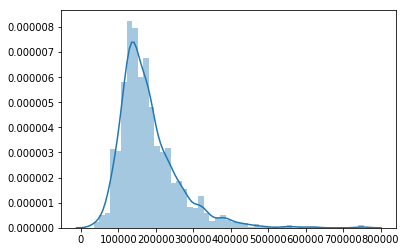

In [8]:
sp = df4.select("SalePrice").collect()
ax = sns.distplot(sp)
plt.show()

正規分布に従っていないので、列SalePriceの値をlogを取った値にする

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,SalePrice2
0,1,60,3,65,8450,0,0,2,2,1,0,1,15,4,3,1,4,7,5,2003,2003,0,5,14,15,4,196,0,4,0,0,4,3,3,706,1,0,150,856,4,2,0,3,856,854,0,1710,1,0,2,1,3,1,0,8,4,0,1,2,2003,0,2,548,5,5,0,0,61,0,0,0,0,1,2,0,0,2,2008,7,5,208500,2566,12.247694
1,2,20,3,80,9600,0,0,2,2,1,4,1,0,3,3,1,6,6,8,1976,1976,0,5,8,9,0,0,3,4,5,0,4,0,6,978,1,0,284,1262,4,2,0,3,1262,0,0,1262,0,1,2,0,3,1,3,6,4,1,5,2,1976,0,2,460,5,5,0,298,0,0,0,0,0,1,2,0,0,5,2007,7,5,181500,2524,12.109011
2,3,60,3,68,11250,0,0,0,2,1,0,1,15,4,3,1,4,7,5,2001,2002,0,5,14,15,4,162,0,4,0,0,4,2,3,486,1,0,434,920,4,2,0,3,920,866,0,1786,1,0,2,1,3,1,0,6,4,1,5,2,2001,0,2,608,5,5,0,0,42,0,0,0,0,1,2,0,0,9,2008,7,5,223500,2706,12.317167
3,4,70,3,60,9550,0,0,0,2,1,2,1,9,4,3,1,4,7,5,1915,1970,0,5,6,5,0,0,3,4,2,4,0,3,6,216,1,0,540,756,4,0,0,3,961,756,0,1717,1,0,1,0,3,1,0,7,4,1,0,0,1998,3,3,642,5,5,0,0,35,272,0,0,0,1,2,0,0,2,2006,7,3,140000,2473,11.849398
4,5,60,3,84,14260,0,0,0,2,1,4,1,4,4,3,1,4,8,5,2000,2000,0,5,14,15,4,350,0,4,0,0,4,4,3,655,1,0,490,1145,4,2,0,3,1145,1053,0,2198,1,0,2,1,4,1,0,9,4,1,5,2,2000,0,3,836,5,5,0,192,84,0,0,0,0,1,2,0,0,12,2008,7,5,250000,3343,12.429216
5,6,50,3,85,14115,0,0,0,2,1,0,1,20,4,3,1,0,5,5,1993,1995,0,5,14,15,0,0,3,4,1,0,4,3,3,732,1,0,64,796,4,2,0,3,796,566,0,1362,1,0,1,1,1,1,3,5,4,0,1,2,1993,3,2,480,5,5,0,40,30,0,320,0,0,1,0,1,700,10,2009,7,5,143000,2158,11.870600
6,7,20,3,75,10084,0,0,2,2,1,0,1,8,4,3,1,6,8,5,2004,2005,0,5,14,15,3,186,0,4,0,2,4,4,3,1369,1,0,317,1686,4,2,0,3,1694,0,0,1694,1,0,2,0,3,1,0,7,4,1,0,2,2004,0,2,636,5,5,0,255,57,0,0,0,0,1,2,0,0,8,2007,7,5,307000,3380,12.634603
7,8,60,3,70,10382,0,0,0,2,1,2,1,5,0,3,1,4,7,6,1973,1973,0,5,0,1,3,240,3,4,5,0,4,2,6,859,4,32,216,1107,4,2,0,3,1107,983,0,2090,1,0,2,1,3,1,3,7,4,2,5,2,1973,0,2,484,5,5,0,235,204,228,0,0,0,1,2,1,350,11,2009,7,5,200000,3197,12.206073
8,9,50,4,51,6120,0,0,2,2,1,0,1,6,2,3,1,0,7,5,1931,1950,0,5,12,5,0,0,3,4,2,4,4,3,1,0,1,0,952,952,4,0,0,1,1022,752,0,1774,0,0,2,0,2,2,3,8,3,2,5,0,1931,3,2,468,4,5,0,90,0,205,0,0,0,1,2,0,0,4,2008,7,3,129900,2726,11.774520
9,10,190,3,50,7420,0,0,2,2,1,2,1,1,2,1,3,7,5,6,1939,1950,0,5,8,9,0,0,3,4,2,4,4,3,3,851,1,0,140,991,4,2,0,3,1077,0,0,1077,1,0,1,0,2,2,3,5,4,2,5,2,1939,0,1,205,0,5,0,0,4,0,0,0,0,1,2,0,0,1,2008,7,5,118000,2068,11.678440


/home/kiuchi/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


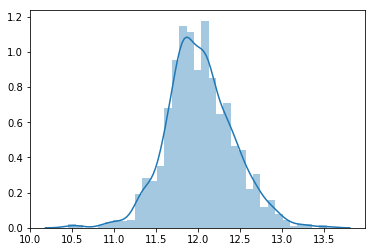

In [9]:
logSalePrice = udf(lambda p: float(np.log(p)), DoubleType())
df5 = df4.withColumn("SalePrice2", logSalePrice(df4.SalePrice))
display(printDf(df5.limit(10)))
lsp = df5.select("SalePrice2").collect()
ax = sns.distplot(lsp)
plt.show()

### どのFeatureが大切なのかチェックする
RandomForestのfeature_importanceによってFeatureの重要度を見る

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fen

None

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,SalePrice2,feature
0,1,60,3,65,8450,0,0,2,2,1,0,1,15,4,3,1,4,7,5,2003,2003,0,5,14,15,4,196,0,4,0,0,4,3,3,706,1,0,150,856,4,2,0,3,856,854,0,1710,1,0,2,1,3,1,0,8,4,0,1,2,2003,0,2,548,5,5,0,0,61,0,0,0,0,1,2,0,0,2,2008,7,5,208500,2566,12.247694,"[60.0, 3.0, 65.0, 8450.0, 0.0, 0.0, 2.0, 2.0, ..."
1,2,20,3,80,9600,0,0,2,2,1,4,1,0,3,3,1,6,6,8,1976,1976,0,5,8,9,0,0,3,4,5,0,4,0,6,978,1,0,284,1262,4,2,0,3,1262,0,0,1262,0,1,2,0,3,1,3,6,4,1,5,2,1976,0,2,460,5,5,0,298,0,0,0,0,0,1,2,0,0,5,2007,7,5,181500,2524,12.109011,"[20.0, 3.0, 80.0, 9600.0, 0.0, 0.0, 2.0, 2.0, ..."
2,3,60,3,68,11250,0,0,0,2,1,0,1,15,4,3,1,4,7,5,2001,2002,0,5,14,15,4,162,0,4,0,0,4,2,3,486,1,0,434,920,4,2,0,3,920,866,0,1786,1,0,2,1,3,1,0,6,4,1,5,2,2001,0,2,608,5,5,0,0,42,0,0,0,0,1,2,0,0,9,2008,7,5,223500,2706,12.317167,"[60.0, 3.0, 68.0, 11250.0, 0.0, 0.0, 0.0, 2.0,..."
3,4,70,3,60,9550,0,0,0,2,1,2,1,9,4,3,1,4,7,5,1915,1970,0,5,6,5,0,0,3,4,2,4,0,3,6,216,1,0,540,756,4,0,0,3,961,756,0,1717,1,0,1,0,3,1,0,7,4,1,0,0,1998,3,3,642,5,5,0,0,35,272,0,0,0,1,2,0,0,2,2006,7,3,140000,2473,11.849398,"[70.0, 3.0, 60.0, 9550.0, 0.0, 0.0, 0.0, 2.0, ..."
4,5,60,3,84,14260,0,0,0,2,1,4,1,4,4,3,1,4,8,5,2000,2000,0,5,14,15,4,350,0,4,0,0,4,4,3,655,1,0,490,1145,4,2,0,3,1145,1053,0,2198,1,0,2,1,4,1,0,9,4,1,5,2,2000,0,3,836,5,5,0,192,84,0,0,0,0,1,2,0,0,12,2008,7,5,250000,3343,12.429216,"[60.0, 3.0, 84.0, 14260.0, 0.0, 0.0, 0.0, 2.0,..."


,Importance,Name
0,0.246772,TotalSF
1,0.220131,OverallQual
2,0.069101,GarageCars
3,0.068012,ExterQual
4,0.052726,GrLivArea


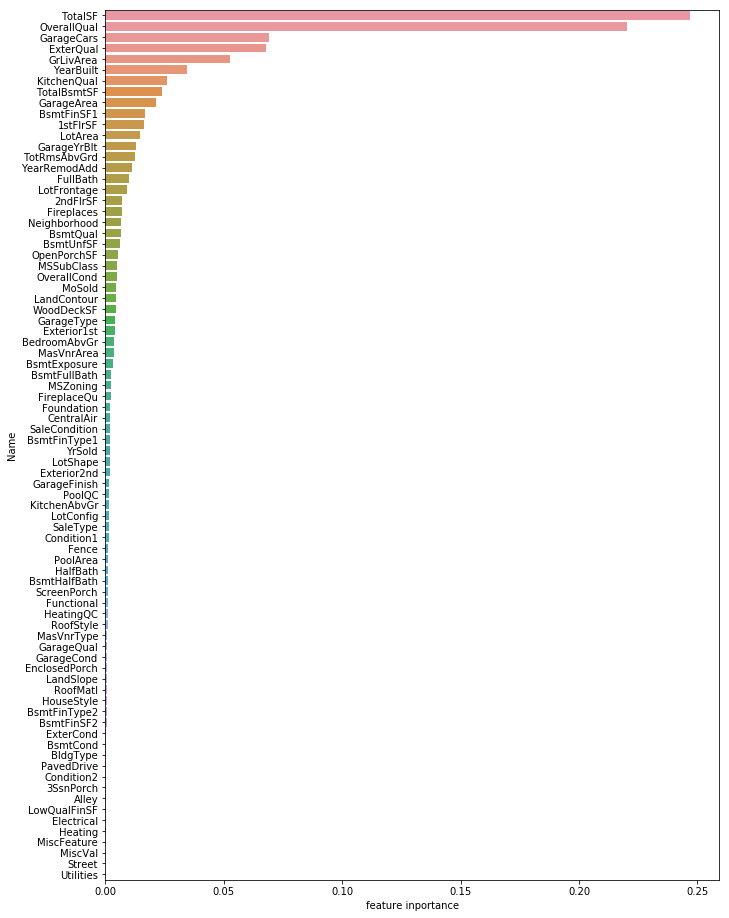

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, Normalizer
from pyspark.ml.regression import RandomForestRegressor as RF

# Feature(説明変数)として使用する列の一覧を作成する
featureCols = df5.columns
featureCols.remove("Id")
featureCols.remove("SalePrice")
featureCols.remove("SalePrice2")
display(print(featureCols))

# Feature対象カラムを結合して特徴ベクトルを作成し、カラム名'feature'に入れる
assembled_feature = VectorAssembler(inputCols=featureCols, outputCol='feature')
pipeline = Pipeline(stages=[assembled_feature])
dfF = pipeline.fit(df5).transform(df5)
display(printDf(dfF.limit(5)))

# RandomForestRegressorモデルを作成する。
# 説明変数は 'feature', 目的変数は 'SalePrice'
rf = RF(labelCol='SalePrice', featuresCol='feature', numTrees=200, maxDepth=20, seed=42)
model = rf.fit(dfF)

# RandomForestによって算出された説明変数の重要度を出力する
#np.argsort(model.featureImportances.toArray())
pdf = pd.DataFrame({'Name': featureCols, 'Importance': model.featureImportances.toArray()})
pdf2 = pdf.sort_values(by=['Importance'], ascending=False).reset_index().drop(['index'], axis=1)
display(pdf2.head(5))
f, ax = plt.subplots(figsize=(11,16))
sns.barplot(x=pdf2["Importance"], y=pdf2["Name"], orient='h')
ax.set_xlabel("feature inportance")
plt.show()

上位30個のFeatureを使用することにする

また、列 TotalSF と列 OverallQual をかけて、列 Interaction を生成する

In [11]:
x_train_df = df5.select(pdf2["Name"][:30].values.tolist())
def addTCol(a, b):
    return int(a*b)
udfAddTCol = udf(addTCol, IntegerType())
x_train_df2 = x_train_df.withColumn("Interaction", udfAddTCol(x_train_df.TotalSF, x_train_df.OverallQual))
y_train_df = df5.select("SalePrice")
display(printDf(x_train_df2.limit(5)))
display(printDf(y_train_df.limit(5)))

,TotalSF,OverallQual,GarageCars,ExterQual,GrLivArea,YearBuilt,KitchenQual,TotalBsmtSF,GarageArea,BsmtFinSF1,1stFlrSF,LotArea,GarageYrBlt,TotRmsAbvGrd,YearRemodAdd,FullBath,LotFrontage,2ndFlrSF,Fireplaces,Neighborhood,BsmtQual,BsmtUnfSF,OpenPorchSF,MSSubClass,OverallCond,MoSold,LandContour,WoodDeckSF,GarageType,Exterior1st,Interaction
0,2566,7,2,0,1710,2003,0,856,548,706,856,8450,2003,8,2003,2,65,854,0,15,0,150,61,60,5,2,2,0,2,14,17962
1,2524,6,2,3,1262,1976,3,1262,460,978,1262,9600,1976,6,1976,2,80,0,1,0,0,284,0,20,8,5,2,298,2,8,15144
2,2706,7,2,0,1786,2001,0,920,608,486,920,11250,2001,6,2002,2,68,866,1,15,0,434,42,60,5,9,2,0,2,14,18942
3,2473,7,3,3,1717,1915,0,756,642,216,961,9550,1998,7,1970,1,60,756,1,9,4,540,35,70,5,2,2,0,0,6,17311
4,3343,8,3,0,2198,2000,0,1145,836,655,1145,14260,2000,9,2000,2,84,1053,1,4,0,490,84,60,5,12,2,192,2,14,26744


,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000


### 各Featureとターゲットの関係を調べる

教師データの各カラムと、列 SalePrice との関係をプロットする

In [12]:
print(x_train_df2.columns)

['TotalSF', 'OverallQual', 'GarageCars', 'ExterQual', 'GrLivArea', 'YearBuilt', 'KitchenQual', 'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1', '1stFlrSF', 'LotArea', 'GarageYrBlt', 'TotRmsAbvGrd', 'YearRemodAdd', 'FullBath', 'LotFrontage', '2ndFlrSF', 'Fireplaces', 'Neighborhood', 'BsmtQual', 'BsmtUnfSF', 'OpenPorchSF', 'MSSubClass', 'OverallCond', 'MoSold', 'LandContour', 'WoodDeckSF', 'GarageType', 'Exterior1st', 'Interaction']


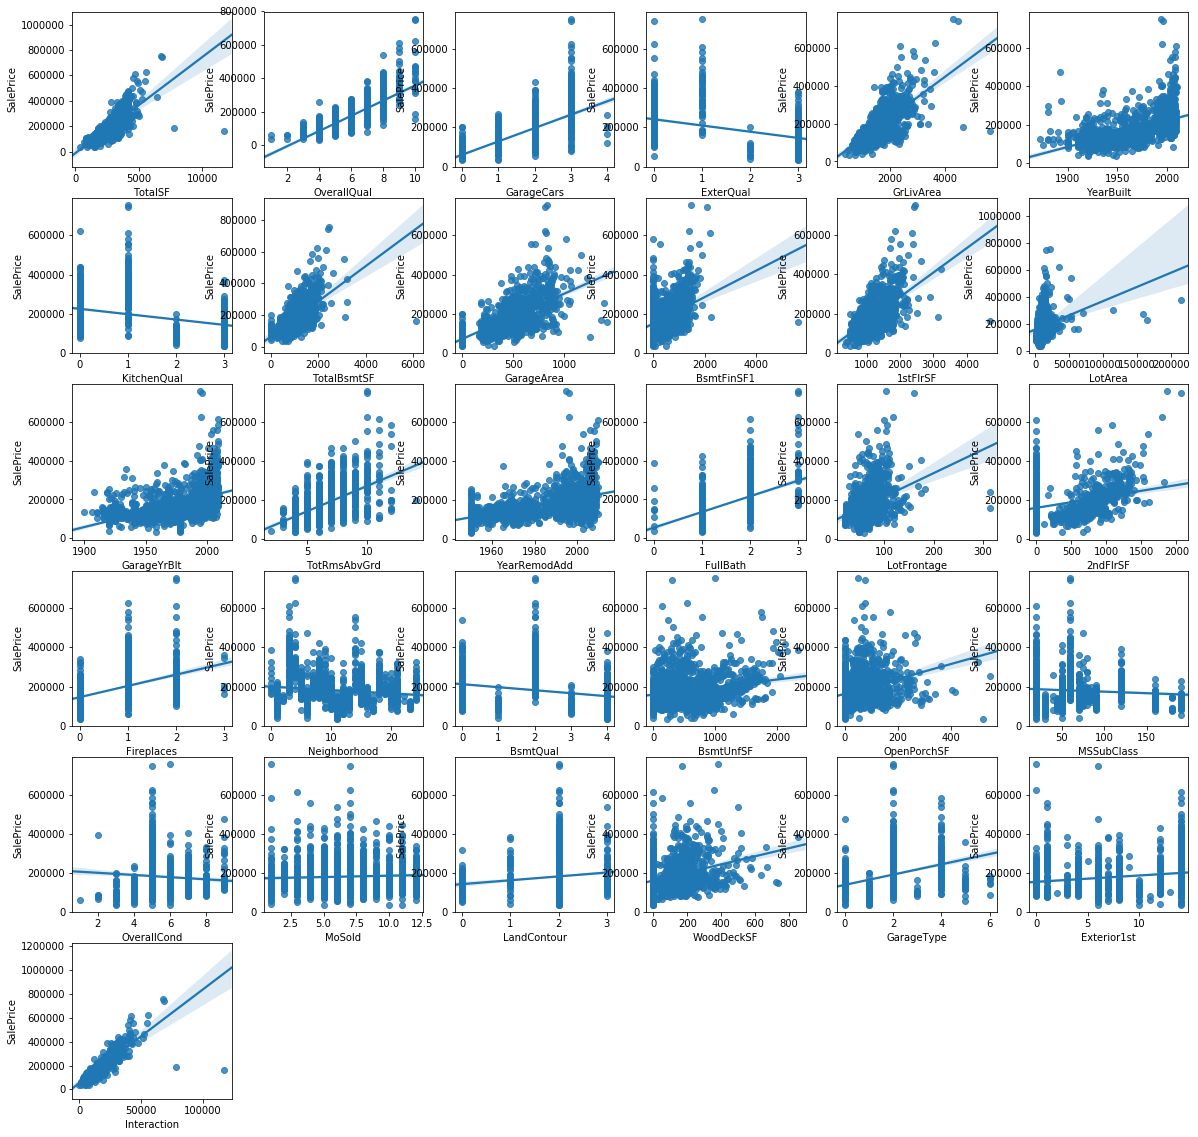

In [13]:
cols = x_train_df2.columns
cols.append("Interaction")
fig = plt.figure(figsize=(20,20))
for i in range(31):
    ax = fig.add_subplot(6,6,i+1)
    sns.regplot(x=x_train_df2.select(cols[i]).toPandas()[cols[i]] , y=y_train_df.toPandas()["SalePrice"])
plt.show()

見ると、以下のデータ(Anomary)は外れ値として扱って良さそう
- TotalSFが 5500 以上で、SalePriceが 300000 以下のもの
- GrLivAreaが 4000 以上で、SalePriceが 300000 以下のもの

上記を取り除いたデータを作成してみる

,TotalSF,OverallQual,GarageCars,ExterQual,GrLivArea,YearBuilt,KitchenQual,TotalBsmtSF,GarageArea,BsmtFinSF1,1stFlrSF,LotArea,GarageYrBlt,TotRmsAbvGrd,YearRemodAdd,FullBath,LotFrontage,2ndFlrSF,Fireplaces,Neighborhood,BsmtQual,BsmtUnfSF,OpenPorchSF,MSSubClass,OverallCond,MoSold,LandContour,WoodDeckSF,GarageType,Exterior1st,Interaction
0,2566,7,2,0,1710,2003,0,856,548,706,856,8450,2003,8,2003,2,65,854,0,15,0,150,61,60,5,2,2,0,2,14,17962
1,2524,6,2,3,1262,1976,3,1262,460,978,1262,9600,1976,6,1976,2,80,0,1,0,0,284,0,20,8,5,2,298,2,8,15144
2,2706,7,2,0,1786,2001,0,920,608,486,920,11250,2001,6,2002,2,68,866,1,15,0,434,42,60,5,9,2,0,2,14,18942
3,2473,7,3,3,1717,1915,0,756,642,216,961,9550,1998,7,1970,1,60,756,1,9,4,540,35,70,5,2,2,0,0,6,17311
4,3343,8,3,0,2198,2000,0,1145,836,655,1145,14260,2000,9,2000,2,84,1053,1,4,0,490,84,60,5,12,2,192,2,14,26744


,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000


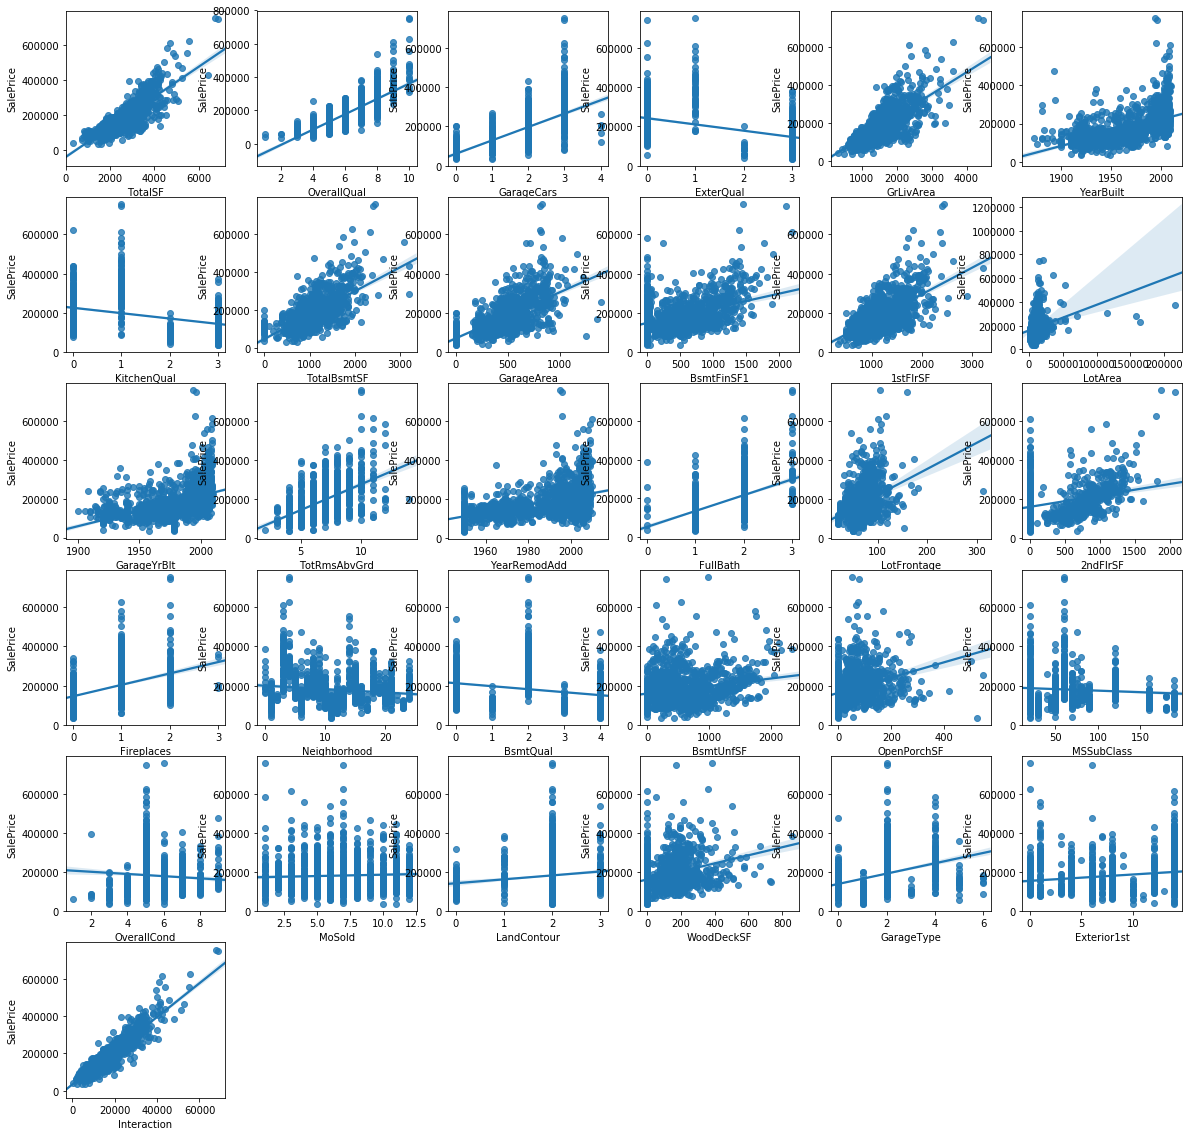

In [14]:
df5_mat = df5.filter(~((df5.TotalSF >= 5500) & (df5.SalePrice <= 300000))) \
             .filter(~((df5.GrLivArea >= 4000) & (df5.SalePrice <= 300000)))
def addTCol(a, b):
    return int(a*b)
udfAddTCol = udf(addTCol, IntegerType())
df5_mat2 = df5_mat.withColumn("Interaction", udfAddTCol(df5_mat.TotalSF, df5_mat.OverallQual))

featureCols = pdf2["Name"][:30].values.tolist()
featureCols.append("Interaction")

xmat = df5_mat2.select(featureCols)
ymat = df5_mat2.select("SalePrice")

display(printDf(xmat.limit(5)))
display(printDf(ymat.limit(5)))

fig = plt.figure(figsize=(20,20))
for i in range(31):
    ax = fig.add_subplot(6,6,i+1)
    sns.regplot(x=xmat.select(cols[i]).toPandas()[xmat.columns[i]] , y=ymat.toPandas()["SalePrice"])
plt.show()

余談だけど、相関関係の調査にはRandomForestのFeature ImportanceよりもSpearman's rankを使用したほうがいいような気もした。上の図だとLabelEncodeしたカラムは必ずしも順番が適切ではないので並び替えたりするのが面倒なのではないだろうか？

### Stacking Emsemble modelの作成

ここまででデータは準備できたので、アンサンブルモデルを作成する。元記事ではXGBoost, NN, SVR(SVM)だが、できるだけSparkだけでやりたいので、LinearRegression(Lasso), RandomForestRegression, Gradient-boosted tree regressionの3つを使ってみる


In [15]:
# Feature vectorを作成
assembled_feature = VectorAssembler(inputCols=featureCols, outputCol='feature')
pipeline = Pipeline(stages=[assembled_feature])
mat2 = pipeline.fit(df5_mat2).transform(df5_mat2)
display(printDf(mat2.limit(5)))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,SalePrice2,Interaction,feature
0,1,60,3,65,8450,0,0,2,2,1,0,1,15,4,3,1,4,7,5,2003,2003,0,5,14,15,4,196,0,4,0,0,4,3,3,706,1,0,150,856,4,2,0,3,856,854,0,1710,1,0,2,1,3,1,0,8,4,0,1,2,2003,0,2,548,5,5,0,0,61,0,0,0,0,1,2,0,0,2,2008,7,5,208500,2566,12.247694,17962,"[2566.0, 7.0, 2.0, 0.0, 1710.0, 2003.0, 0.0, 8..."
1,2,20,3,80,9600,0,0,2,2,1,4,1,0,3,3,1,6,6,8,1976,1976,0,5,8,9,0,0,3,4,5,0,4,0,6,978,1,0,284,1262,4,2,0,3,1262,0,0,1262,0,1,2,0,3,1,3,6,4,1,5,2,1976,0,2,460,5,5,0,298,0,0,0,0,0,1,2,0,0,5,2007,7,5,181500,2524,12.109011,15144,"[2524.0, 6.0, 2.0, 3.0, 1262.0, 1976.0, 3.0, 1..."
2,3,60,3,68,11250,0,0,0,2,1,0,1,15,4,3,1,4,7,5,2001,2002,0,5,14,15,4,162,0,4,0,0,4,2,3,486,1,0,434,920,4,2,0,3,920,866,0,1786,1,0,2,1,3,1,0,6,4,1,5,2,2001,0,2,608,5,5,0,0,42,0,0,0,0,1,2,0,0,9,2008,7,5,223500,2706,12.317167,18942,"[2706.0, 7.0, 2.0, 0.0, 1786.0, 2001.0, 0.0, 9..."
3,4,70,3,60,9550,0,0,0,2,1,2,1,9,4,3,1,4,7,5,1915,1970,0,5,6,5,0,0,3,4,2,4,0,3,6,216,1,0,540,756,4,0,0,3,961,756,0,1717,1,0,1,0,3,1,0,7,4,1,0,0,1998,3,3,642,5,5,0,0,35,272,0,0,0,1,2,0,0,2,2006,7,3,140000,2473,11.849398,17311,"[2473.0, 7.0, 3.0, 3.0, 1717.0, 1915.0, 0.0, 7..."
4,5,60,3,84,14260,0,0,0,2,1,4,1,4,4,3,1,4,8,5,2000,2000,0,5,14,15,4,350,0,4,0,0,4,4,3,655,1,0,490,1145,4,2,0,3,1145,1053,0,2198,1,0,2,1,4,1,0,9,4,1,5,2,2000,0,3,836,5,5,0,192,84,0,0,0,0,1,2,0,0,12,2008,7,5,250000,3343,12.429216,26744,"[3343.0, 8.0, 3.0, 0.0, 2198.0, 2000.0, 0.0, 1..."


3つ(LinearRegression(Lasso), RandomForestRegression, Gradient-boosted tree regression)のモデルをつくり、教師データのfeature vectorで予測させる

In [16]:
# Lasso
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="feature", labelCol="SalePrice", predictionCol="predict", elasticNetParam=1)
model_lr = lr.fit(mat2)
mat2_lr_pred = model_lr.transform(mat2)
display(printDf(mat2_lr_pred.limit(3)))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,SalePrice2,Interaction,feature,predict
0,1,60,3,65,8450,0,0,2,2,1,0,1,15,4,3,1,4,7,5,2003,2003,0,5,14,15,4,196,0,4,0,0,4,3,3,706,1,0,150,856,4,2,0,3,856,854,0,1710,1,0,2,1,3,1,0,8,4,0,1,2,2003,0,2,548,5,5,0,0,61,0,0,0,0,1,2,0,0,2,2008,7,5,208500,2566,12.247694,17962,"[2566.0, 7.0, 2.0, 0.0, 1710.0, 2003.0, 0.0, 8...",209447.179850
1,2,20,3,80,9600,0,0,2,2,1,4,1,0,3,3,1,6,6,8,1976,1976,0,5,8,9,0,0,3,4,5,0,4,0,6,978,1,0,284,1262,4,2,0,3,1262,0,0,1262,0,1,2,0,3,1,3,6,4,1,5,2,1976,0,2,460,5,5,0,298,0,0,0,0,0,1,2,0,0,5,2007,7,5,181500,2524,12.109011,15144,"[2524.0, 6.0, 2.0, 3.0, 1262.0, 1976.0, 3.0, 1...",194056.357968
2,3,60,3,68,11250,0,0,0,2,1,0,1,15,4,3,1,4,7,5,2001,2002,0,5,14,15,4,162,0,4,0,0,4,2,3,486,1,0,434,920,4,2,0,3,920,866,0,1786,1,0,2,1,3,1,0,6,4,1,5,2,2001,0,2,608,5,5,0,0,42,0,0,0,0,1,2,0,0,9,2008,7,5,223500,2706,12.317167,18942,"[2706.0, 7.0, 2.0, 0.0, 1786.0, 2001.0, 0.0, 9...",216558.392118


In [17]:
# RandomForest Regression
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="feature", labelCol="SalePrice", predictionCol="predict", numTrees=200, maxDepth=20, seed=42)
model_rf = rf.fit(mat2)
mat2_rf_pred = model_rf.transform(mat2)
display(printDf(mat2_rf_pred.limit(3)))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,SalePrice2,Interaction,feature,predict
0,1,60,3,65,8450,0,0,2,2,1,0,1,15,4,3,1,4,7,5,2003,2003,0,5,14,15,4,196,0,4,0,0,4,3,3,706,1,0,150,856,4,2,0,3,856,854,0,1710,1,0,2,1,3,1,0,8,4,0,1,2,2003,0,2,548,5,5,0,0,61,0,0,0,0,1,2,0,0,2,2008,7,5,208500,2566,12.247694,17962,"[2566.0, 7.0, 2.0, 0.0, 1710.0, 2003.0, 0.0, 8...",209572.78
1,2,20,3,80,9600,0,0,2,2,1,4,1,0,3,3,1,6,6,8,1976,1976,0,5,8,9,0,0,3,4,5,0,4,0,6,978,1,0,284,1262,4,2,0,3,1262,0,0,1262,0,1,2,0,3,1,3,6,4,1,5,2,1976,0,2,460,5,5,0,298,0,0,0,0,0,1,2,0,0,5,2007,7,5,181500,2524,12.109011,15144,"[2524.0, 6.0, 2.0, 3.0, 1262.0, 1976.0, 3.0, 1...",178416.50
2,3,60,3,68,11250,0,0,0,2,1,0,1,15,4,3,1,4,7,5,2001,2002,0,5,14,15,4,162,0,4,0,0,4,2,3,486,1,0,434,920,4,2,0,3,920,866,0,1786,1,0,2,1,3,1,0,6,4,1,5,2,2001,0,2,608,5,5,0,0,42,0,0,0,0,1,2,0,0,9,2008,7,5,223500,2706,12.317167,18942,"[2706.0, 7.0, 2.0, 0.0, 1786.0, 2001.0, 0.0, 9...",222040.80


In [18]:
# Gradient-boosted tree regression
from pyspark.ml.regression import GBTRegressor
gb = GBTRegressor(featuresCol="feature", labelCol="SalePrice", predictionCol="predict")
model_gb = gb.fit(mat2)
mat2_gb_pred = model_gb.transform(mat2)
display(printDf(mat2_gb_pred.limit(3)))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,SalePrice2,Interaction,feature,predict
0,1,60,3,65,8450,0,0,2,2,1,0,1,15,4,3,1,4,7,5,2003,2003,0,5,14,15,4,196,0,4,0,0,4,3,3,706,1,0,150,856,4,2,0,3,856,854,0,1710,1,0,2,1,3,1,0,8,4,0,1,2,2003,0,2,548,5,5,0,0,61,0,0,0,0,1,2,0,0,2,2008,7,5,208500,2566,12.247694,17962,"[2566.0, 7.0, 2.0, 0.0, 1710.0, 2003.0, 0.0, 8...",212626.943362
1,2,20,3,80,9600,0,0,2,2,1,4,1,0,3,3,1,6,6,8,1976,1976,0,5,8,9,0,0,3,4,5,0,4,0,6,978,1,0,284,1262,4,2,0,3,1262,0,0,1262,0,1,2,0,3,1,3,6,4,1,5,2,1976,0,2,460,5,5,0,298,0,0,0,0,0,1,2,0,0,5,2007,7,5,181500,2524,12.109011,15144,"[2524.0, 6.0, 2.0, 3.0, 1262.0, 1976.0, 3.0, 1...",179138.312759
2,3,60,3,68,11250,0,0,0,2,1,0,1,15,4,3,1,4,7,5,2001,2002,0,5,14,15,4,162,0,4,0,0,4,2,3,486,1,0,434,920,4,2,0,3,920,866,0,1786,1,0,2,1,3,1,0,6,4,1,5,2,2001,0,2,608,5,5,0,0,42,0,0,0,0,1,2,0,0,9,2008,7,5,223500,2706,12.317167,18942,"[2706.0, 7.0, 2.0, 0.0, 1786.0, 2001.0, 0.0, 9...",213481.152647


3つのアルゴリズムの予測結果を結合し、アンサンブルを行う

In [19]:
# LassoのDataframeからIdと予測結果だけを取り出し
ens_df_lr = mat2_lr_pred.select([mat2_lr_pred.Id, mat2_lr_pred.predict]) \
                        .withColumnRenamed("predict", "pred_lr") \
                        .withColumnRenamed("Id", "Id_lr")
# RandomForestのDataframeからIdと予測結果だけを取り出し
ens_df_rf = mat2_rf_pred.select([mat2_rf_pred.Id, mat2_rf_pred.predict]) \
                        .withColumnRenamed("predict", "pred_rf") \
                        .withColumnRenamed("Id", "Id_rf")
# Gradient-boosted tree regressionのDataframeはfeature vectorのみ落とす
ens_df_gb = mat2_gb_pred.withColumnRenamed("predict", "pred_gb") \
                        .withColumnRenamed("Id", "Id_gb") \
                        .drop("feature")
# 3つのDataframeをjoin
ens_df = ens_df_lr.join(ens_df_rf, ens_df_lr.Id_lr == ens_df_rf.Id_rf)
ens_df2 = ens_df.join(ens_df_gb, ens_df.Id_lr == ens_df_gb.Id_gb)
display(printDf(ens_df2.limit(3)))

# 3つの予測結果からFeature vectorを作成
assembled_feature = VectorAssembler(inputCols=["pred_lr", "pred_rf", "pred_gb"], outputCol='feature')
pipeline = Pipeline(stages=[assembled_feature])
ens_df3 = pipeline.fit(ens_df2).transform(ens_df2)
display(printDf(ens_df3.select(ens_df3.pred_lr, ens_df3.pred_rf, ens_df3.pred_gb, ens_df3.feature, ens_df3.SalePrice).limit(5)))

,Id_lr,pred_lr,Id_rf,pred_rf,Id_gb,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,SalePrice2,Interaction,pred_gb
0,1,209447.179850,1,209572.78,1,60,3,65,8450,0,0,2,2,1,0,1,15,4,3,1,4,7,5,2003,2003,0,5,14,15,4,196,0,4,0,0,4,3,3,706,1,0,150,856,4,2,0,3,856,854,0,1710,1,0,2,1,3,1,0,8,4,0,1,2,2003,0,2,548,5,5,0,0,61,0,0,0,0,1,2,0,0,2,2008,7,5,208500,2566,12.247694,17962,212626.943362
1,2,194056.357968,2,178416.50,2,20,3,80,9600,0,0,2,2,1,4,1,0,3,3,1,6,6,8,1976,1976,0,5,8,9,0,0,3,4,5,0,4,0,6,978,1,0,284,1262,4,2,0,3,1262,0,0,1262,0,1,2,0,3,1,3,6,4,1,5,2,1976,0,2,460,5,5,0,298,0,0,0,0,0,1,2,0,0,5,2007,7,5,181500,2524,12.109011,15144,179138.312759
2,3,216558.392118,3,222040.80,3,60,3,68,11250,0,0,0,2,1,0,1,15,4,3,1,4,7,5,2001,2002,0,5,14,15,4,162,0,4,0,0,4,2,3,486,1,0,434,920,4,2,0,3,920,866,0,1786,1,0,2,1,3,1,0,6,4,1,5,2,2001,0,2,608,5,5,0,0,42,0,0,0,0,1,2,0,0,9,2008,7,5,223500,2706,12.317167,18942,213481.152647


,pred_lr,pred_rf,pred_gb,feature,SalePrice
0,209447.179850,209572.780000,212626.943362,"[209447.17984966282, 209572.78, 212626.9433616...",208500
1,194056.357968,178416.500000,179138.312759,"[194056.3579678738, 178416.5, 179138.31275891204]",181500
2,216558.392118,222040.800000,213481.152647,"[216558.39211802278, 222040.8, 213481.15264749...",223500
3,163137.506547,151572.938333,189289.195290,"[163137.50654663867, 151572.93833333335, 18928...",140000
4,298900.116379,265661.390000,300790.177643,"[298900.11637878325, 265661.39, 300790.1776427...",250000


### 最終的なモデルを作成

Lassoでアンサンブルの回帰モデルを作成

In [20]:
lr2 = LinearRegression(featuresCol="feature", labelCol="SalePrice", predictionCol="predict", elasticNetParam=1)
model_lr2 = lr2.fit(ens_df3)
ens_pred = model_lr2.transform(ens_df3)
display(printDf(ens_pred.select(ens_pred.pred_lr, ens_pred.pred_rf, ens_pred.pred_gb, ens_pred.feature, ens_pred.SalePrice, ens_pred.predict).limit(3)))

,pred_lr,pred_rf,pred_gb,feature,SalePrice,predict
0,209447.179850,209572.78,212626.943362,"[209447.17984966282, 209572.78, 212626.9433616...",208500,209898.234217
1,194056.357968,178416.50,179138.312759,"[194056.3579678738, 178416.5, 179138.31275891204]",181500,173762.600455
2,216558.392118,222040.80,213481.152647,"[216558.39211802278, 222040.8, 213481.15264749...",223500,224188.881730


### 最終モデルを使用して予測

テスト用のデータを作成

In [21]:
dftest = spark.read.format("csv").options(header="true", nanValue="NA", nullValue="NA", inferSchema=True).load("test.csv.gz")
dftest2 = fillNa(dftest, "mean")
#display(printDf(dftest2.limit(10)))
(dftest3, labelDict2) = labelEncode(dftest2, labelDict)
#display(printDf(dftest3.limit(10)))

# TotalSF列を生成
def addFSColumns(bsmt, fflr, sflr):
    return int(bsmt+fflr+sflr)
udfAddSFColumns = udf(addFSColumns, IntegerType())
dftest4 = dftest3.withColumn("TotalSF", udfAddSFColumns(dftest3["TotalBsmtSF"], dftest3["1stFlrSF"], dftest3["2ndFlrSF"]))

# Interaction列を生成
def addTCol(a, b):
    return int(a*b)
udfAddTCol = udf(addTCol, IntegerType())
dftest5 = dftest4.withColumn("Interaction", udfAddTCol(dftest4.TotalSF, dftest4.OverallQual))

# Feature vectorを作成
assembled_feature = VectorAssembler(inputCols=featureCols, outputCol='feature')
pipeline = Pipeline(stages=[assembled_feature])
dftest6 = pipeline.fit(dftest5).transform(dftest5)
display(printDf(dftest6.select(dftest6.Id, dftest6.feature).limit(5)))

,Id,feature
0,1461,"[1778.0, 5.0, 1.0, 3.0, 896.0, 1961.0, 3.0, 88..."
1,1462,"[2658.0, 6.0, 1.0, 3.0, 1329.0, 1958.0, 0.0, 1..."
2,1463,"[2557.0, 5.0, 2.0, 3.0, 1629.0, 1997.0, 3.0, 9..."
3,1464,"[2530.0, 6.0, 2.0, 3.0, 1604.0, 1998.0, 0.0, 9..."
4,1465,"[2560.0, 8.0, 2.0, 0.0, 1280.0, 1992.0, 0.0, 1..."


In [22]:
test = dftest6.select(dftest6.Id, dftest6.feature)

# 1段階目-Lassoの予測
test_lr_pred = model_lr.transform(test)
#display(printDf(test_lr_pred.limit(3)))
# 1段階目-RandomForestの予測
test_rf_pred = model_rf.transform(test)
#display(printDf(test_rf_pred.limit(3)))
# 1段階目-Gradient-boosted tree regressionの予測
test_gb_pred = model_gb.transform(test)
#display(printDf(test_gb_pred.limit(3)))

# 結果をアンサンブル
test_lr_pred2 = test_lr_pred.select(test_lr_pred.Id, test_lr_pred.predict) \
                            .withColumnRenamed("predict", "pred_lr") \
                            .withColumnRenamed("Id", "Id_lr") \
                            .drop("feature")
#display(printDf(test_lr_pred2.limit(3)))
test_rf_pred2 = test_rf_pred.select(test_rf_pred.Id, test_rf_pred.predict) \
                            .withColumnRenamed("predict", "pred_rf") \
                            .withColumnRenamed("Id", "Id_rf") \
                            .drop("feature")
#display(printDf(test_rf_pred2.limit(3)))
test_gb_pred2 = test_gb_pred.select(test_gb_pred.Id, test_gb_pred.predict) \
                            .withColumnRenamed("predict", "pred_gb") \
                            .withColumnRenamed("Id", "Id_gb") \
                            .drop("feature")
#display(printDf(test_gb_pred2.limit(3)))
test_ens = test_lr_pred2.join(test_rf_pred2, test_lr_pred2.Id_lr == test_rf_pred2.Id_rf)
test_ens2 = test_ens.join(test_gb_pred2, test_ens.Id_lr == test_gb_pred2.Id_gb) \
                    .withColumnRenamed("Id_lr", "Id") \
                    .drop("Id_rf", "Id_gb")
#display(printDf(test_ens2.limit(3)))

# 3つの予測結果からFeature vectorを作成
assembled_feature = VectorAssembler(inputCols=["pred_lr", "pred_rf", "pred_gb"], outputCol='feature')
pipeline = Pipeline(stages=[assembled_feature])
test_ens3 = pipeline.fit(test_ens2).transform(test_ens2)
#display(printDf(test_ens3.limit(5)))

# アンサンブルモデルで予測値を追加
test_pred = model_lr2.transform(test_ens3)
display(printDf(test_pred.select(test_pred.Id, test_pred.pred_lr, test_pred.pred_rf, test_pred.pred_gb, test_pred.predict).limit(3)))

,Id,pred_lr,pred_rf,pred_gb,predict
0,1461,127116.830606,127915.674,122343.962193,126288.412307
1,1462,167891.182767,163875.200,182368.519790,161784.259950
2,1463,182938.707250,175561.670,163147.548567,173096.869341


### 提出用データの作成

In [23]:
test_pred.select(test_pred.Id, test_pred.predict) \
         .withColumnRenamed("predict", "SalePrice") \
         .write.format("csv").options(header="true", nanValue="NA", nullValue="NA", inferSchema=True).save("houseprice.csv")